# Assignment 3 Gradient Descent

Name: Yizhi Zhou

Student No.:1003002396

Date: Mar 11, 2019

In [1]:
from data_utils import load_dataset
import numpy as np
import scipy as sp
import pandas as pd
from numpy import dot
import matplotlib.pyplot as plt
import copy

_COLORS = ['#d6616b', '#e6550d', '#fdae6b', '#e7ba52', '#e69fa5', '#dbdb8d']
_ITERCAP = 1000

## Linear Regression
Linear regression is used to predict the value of the _pumadyn32nm_ dataset. __Gradient Descent__ and __Stochastic Gradient Descent__ are used to find the weights that minimizes the loss function of __Least Square Error__. 

The Gradient Descent converges when the loss produced after two consecutive rounds differ from their previous rounds by errors smaller than the errorbound. The Stochastic one converges by having 10 rounds, which don't have to be consecutive, but all their losses have to either differ with their previous ones by numbers smaller than the errorbound, or be greater than the previous minimum.

In [2]:
_OPTIMAL_LOSS = 0.7216104721384756
class LinearRegression:
    def __init__(self):
        self.dataset = 'pumadyn32nm'
        self.x_train, self.x_valid, self.x_test, self.y_train, self.y_valid, self.y_test  = load_dataset(self.dataset)

        # Extract the first 1000 data points
        self.x_train, self.y_train = self.x_train[:1000], self.y_train[:1000]

        # Add x0 = 1 to each x vector
        x0 = np.ones((np.shape(self.x_train)[0], 1))
        self.x_train = np.concatenate((x0, self.x_train), axis=1)
        x0 = np.ones((np.shape(self.x_test)[0], 1))
        self.x_test = np.concatenate((x0, self.x_test), axis=1)

        self.num_train = 1000
        (self.num_test, self.num_dimension) = self.x_test.shape


    def preprocessSGD(self):
        self.indices = list(range(self.num_train))
        # np.random.seed(666)
        

    def setParameters(self, convergenceError, learningRate, batchSize=1, GDvisualization=False):
        self.errorBound = convergenceError
        self.learningRate = learningRate
        self.stepsize = learningRate/self.num_train
        self.batchSize = batchSize
        self.num_batches = self.num_train/batchSize
        self.plotGD = GDvisualization


    def getLoss(self, w, X, Y):
        '''
        Function of column vector w, loss function for least square error
        Output: scaler value of loss
        '''
        return ((Y - X.dot(w)).T.dot(Y - X.dot(w))[0][0])/(self.num_train)


    def getGradient(self, w, X, Y):
        '''
        Derivative/gradient of column vector w, loss function for least square error
        Output: column vector, the gradient
        '''
        return 2 * X.T.dot(X.dot(w) - Y)


    def getGDWeight(self):
        '''
        Get the exact gradient descent weight, full-batch
        Lerning rate is set to be a constant here
        '''
        w, grad = np.zeros((self.num_dimension, 1)), np.ones((self.num_dimension, 1))*float('inf')
        error, stablized, iter, ROUND, loss, lossMin, LOSS = float('inf'), 0, 0, [], float('inf'), float('inf'), []

        while stablized <= 1:
            ROUND.append(iter)
            loss = self.getLoss(w, self.x_train, self.y_train)
            LOSS.append(loss)
            
            if iter >= _ITERCAP:
                print('Exceeded', _ITERCAP, 'iterations!')
                break

            #Convergence conditions
            error = abs(_OPTIMAL_LOSS - loss)
            if error <= self.errorBound:
                stablized += 0.2
            else:
                stablized -= 0.2

            #Get the next iteration
            gradPrev = copy.deepcopy(grad)
            grad = self.getGradient(w, self.x_train, self.y_train)
            w -= self.stepsize * grad
            # error = np.linalg.norm(gradPrev - grad)

            #Record iterations
            iter += 1
        
        if self.plotGD:
            plt.style.use('bmh')
            plt.plot(ROUND, LOSS, label = 'Learning rate = %f'%(self.learningRate), color=_COLORS[colorIndex])
            plt.legend()
            plt.title('Least Square Error vs. Gradient Descent Iteration \n Optimal found at iteration %d with a loss of %1.4f' %(iter, loss), loc='center', size=12)
            # plt.show()
        return w, iter


    def getSGDWeight(self):
        '''
        Get the exact gradient descent weight, full-batch
        Lerning rate is set to be a constant here
        '''
        w, grad, gradMin = np.zeros((self.num_dimension, 1)), np.ones((self.num_dimension, 1))*float('inf'), np.zeros((self.num_dimension, 1))
        error, stablized, iter, ROUND, loss, lossMin, LOSS = float('inf'), 0, 0, [], float('inf'), float('inf'), []
        
        ROUND.append(iter)
        loss = self.getLoss(w, self.x_train, self.y_train)
        LOSS.append(loss)

        while stablized <= 1:            
            if iter >= _ITERCAP*12:
                print('Exceeded the cap of iterations!')
                break

            #Get the next iteration
            np.random.shuffle(self.indices)
            self.x_train_Random, self.y_train_Random = self.x_train[self.indices], self.y_train[self.indices]
            for i in range(0, self.num_train, self.batchSize):
                X, Y = self.x_train_Random[i:i+self.batchSize], self.y_train_Random[i:i+self.batchSize]
                grad = self.getGradient(w, X, Y)
                w -= self.stepsize * grad
                #error = np.linalg.norm(gradMin - grad)
                
                #Record iterations
                iter += 1
                ROUND.append(iter)
                loss = self.getLoss(w, self.x_train, self.y_train)
                LOSS.append(loss)

                #Convergence conditions
                error = abs(_OPTIMAL_LOSS - loss)
                if error <= self.errorBound:
                    stablized += 0.1
                    #gradMin = copy.deepcopy(grad)
                if stablized > 1:
                    break
            
        if self.plotGD:
            plt.style.use('bmh')
            plt.plot(ROUND, LOSS, label = 'Learning rate = %f'%(self.learningRate), color=_COLORS[colorIndex])
            plt.legend()
            plt.title('Negative Log Probability vs. Stochastic Gradient Descent Iteration \n Optimal found at iteration %d with a loss of %1.4f' %(iter, loss), loc='center', size=12)
            # plt.show()
        return w, iter


    def getOptimalWeight(self):
        '''
        Get the exact optimal weight using Singular Value Decomposition, full-batch
        '''
        U, s, VT = np.linalg.svd(self.x_train, full_matrices=False) # The economy SVD (if want full SVD, change the second parameter to True)
        S = np.zeros((U.shape[1], VT.shape[0]))
        # print('Dimensions:', U.shape, S.shape, VT.shape, '\nSVD Composition:', U.dot(S.dot(VT)))
        S[:VT.shape[0], :VT.shape[0]] = np.diag(s)
        w = VT.T.dot(np.linalg.inv(S)).dot(U.T).dot(self.y_train)
        return w


    def runRegression(self, method, display=False):
        if method == 'SVD':
            self.w, iter = self.getOptimalWeight(), 1
        elif method == 'GD':
            self.w, iter = self.getGDWeight()
        elif method == 'SGD':
            self.preprocessSGD()
            self.w, iter = self.getSGDWeight()

        x, y_actual = self.x_test, self.y_test
        y_predicted = x.dot(self.w)
        rmse = np.sqrt(pow(np.array(y_predicted-y_actual), 2).mean())
        print('RMSE is', rmse, 'for data', self.dataset, 'with', method, 'at iteration', iter)

        if display:
            plt.style.use('bmh')
            plt.scatter(x[:, 1], y_actual[:, 0], s=3, color=_COLORS[2])
            plt.scatter(x[:, 1], y_predicted[:, 0], marker = '*', s=3, color=_COLORS[0])
            plt.legend(('Actual', 'Prediction'))
            # plt.plot(X[:, 0], Y_predicted[:, 0], linewidth=1, color=_COLORS[0])
            plt.title('Linear Regression on the test set of "%s" with %s\n Resulting RMSE = %1.4f' %(self.dataset, method, rmse), loc='center', size=12)
            plt.show()
        return rmse

In [3]:
SVD = LinearRegression()
minRMSE = SVD.runRegression('SVD')
minLoss = SVD.getLoss(SVD.w, SVD.x_train, SVD.y_train)

RMSE is 0.8706531086227401 for data pumadyn32nm with SVD at iteration 1


RMSE is 0.869628046120264 for data pumadyn32nm with GD at iteration 211
RMSE is 0.8699291382210358 for data pumadyn32nm with GD at iteration 45
RMSE is 0.8703225484689252 for data pumadyn32nm with GD at iteration 26
RMSE is 0.8706530867892146 for data pumadyn32nm with GD at iteration 10


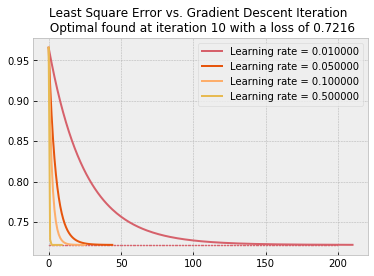

In [4]:
GD = LinearRegression()
global colorIndex
colorIndex = 0
for learningRate in [0.01, 0.05, 0.1, 0.5]:
    GD.setParameters(convergenceError=0.005, learningRate=learningRate, GDvisualization=True)
    GD.runRegression('GD')
    colorIndex += 1
plt.scatter(np.array(range(200)), minLoss*np.ones(200), s=1, color=_COLORS[0])
plt.show()

Exceeded the cap of iterations!
RMSE is 0.9250571774523028 for data pumadyn32nm with SGD at iteration 12000
Exceeded the cap of iterations!
RMSE is 0.8708693068090092 for data pumadyn32nm with SGD at iteration 12000
RMSE is 0.8671389308791445 for data pumadyn32nm with SGD at iteration 10243
RMSE is 0.8680704350510948 for data pumadyn32nm with SGD at iteration 2597


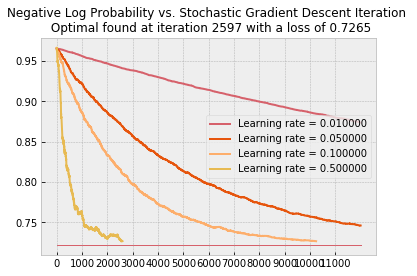

In [12]:
SGD = LinearRegression()
global colorIndex
colorIndex = 0
for learningRate in [0.01, 0.05, 0.1, 0.5]:
    SGD.setParameters(convergenceError=0.005, learningRate=learningRate, batchSize=1, GDvisualization=True)
    SGD.runRegression('SGD')
    colorIndex += 1
plt.scatter(np.array(range(12000)), minLoss*np.ones(12000), s=0.2, color=_COLORS[0])
plt.xticks(np.arange(0, 12000, step=1000.0))
plt.show()

## Logistic Regression
The __Sigmoid activation function__ is used to implement a binary classification. 

The loss function to minimize is the negative form of the log probability from a __Bernoulli distribution__. 

The optimal weights are found by the same __Gradient Descent__ algorithm and __Stochastic Gradient Descent__ like in the previous question.

In [5]:
_OPTIMAL_LOSS = 0.4874
class LogisticRegression:
    def __init__(self):
        self.dataset = 'iris'
        self.x_train, self.x_valid, self.x_test, self.y_train, self.y_valid, self.y_test  = load_dataset(self.dataset)
        self.y_train, self.y_valid, self.y_test = self.y_train[:,(1,)], self.y_valid[:,(1,)], self.y_test[:,(1,)]
        self.x_train = np.concatenate([self.x_train, self.x_valid])
        self.y_train = np.concatenate([self.y_train, self.y_valid])

        # Add x0 = 1 to each x vector
        x0 = np.ones((np.shape(self.x_train)[0], 1))
        self.x_train = np.concatenate((x0, self.x_train), axis=1)
        x0 = np.ones((np.shape(self.x_test)[0], 1))
        self.x_test = np.concatenate((x0, self.x_test), axis=1)

        self.num_train = self.x_train.shape[0]
        (self.num_test, self.num_dimension) = self.x_test.shape


    def sigmoidProbability(self, theta, x):
        # Returns the probability after passing through sigmoid
        z = np.dot(x, theta)
        return 1 / (1 + np.exp(-z))


    def preprocessSGD(self):
        self.indices = list(range(self.num_train))
        # np.random.seed(666)

    def setParameters(self, convergenceError, learningRate, batchSize=1, GDvisualization=False):
        self.errorBound = convergenceError
        self.learningRate = learningRate
        self.stepsize = learningRate/self.num_train
        self.batchSize = batchSize
        self.num_batches = self.num_train/batchSize
        self.plotGD = GDvisualization


    def getLoss(self, w, X, Y):
        '''
        Function of column vector w, loss function for least square error
        Output: scaler value of loss
        '''
        f = self.sigmoidProbability(w, X)
        return -(1/self.num_train) * np.sum(Y * np.log(f) + (1 - Y) * np.log(1 - f))


    def getGradient(self, w, X, Y):
        '''
        Derivative/gradient of column vector w, loss function for least square error
        Output: column vector, the gradient
        '''
        return np.dot(X.T, self.sigmoidProbability(w, X) - Y)


    def getGDWeight(self):
        '''
        Get the exact gradient descent weight, full-batch
        Lerning rate is set to be a constant here
        '''
        w, grad = np.zeros((self.num_dimension, 1)), np.ones((self.num_dimension, 1))*float('inf')
        error, stablized, iter, ROUND, loss, lossMin, LOSS = float('inf'), 0, 0, [], float('inf'), float('inf'), []
            
        while stablized <= 1:
            #Record iterations
            iter += 1
            ROUND.append(iter)
            loss = self.getLoss(w, self.x_train, self.y_train)
            LOSS.append(loss)
            #error = abs(LOSS[-1]-LOSS[-2])
            
            if iter >= _ITERCAP:
                print('Exceeded', _ITERCAP, 'iterations!')
                break

            #Convergence conditions
            error = abs(_OPTIMAL_LOSS - loss)
            if error <= self.errorBound:
                stablized += 0.2
            else:
                stablized -= 0.2

            #Get the next iteration
            gradPrev = copy.deepcopy(grad)
            grad = self.getGradient(w, self.x_train, self.y_train)
            w -= self.stepsize * grad
            # error = np.linalg.norm(gradPrev - grad)
        
        if self.plotGD:
            plt.style.use('bmh')
            plt.plot(ROUND, LOSS, label = 'Learning rate = %f'%(self.learningRate), color=_COLORS[colorIndex])
            plt.legend()
            plt.title('Negative Log Probability vs. Gradient Descent Iteration \n Optimal found at iteration %d with a loss of %1.4f' %(iter, loss), loc='center', size=12)
            # plt.show()
        return w, iter


    def getSGDWeight(self):
        '''
        Get the exact gradient descent weight, full-batch
        Lerning rate is set to be a constant here
        '''
        w, grad, gradMin = np.zeros((self.num_dimension, 1)), np.ones((self.num_dimension, 1))*float('inf'), np.zeros((self.num_dimension, 1))
        error, stablized, iter, ROUND, loss, lossMin, LOSS = float('inf'), 0, 0, [], float('inf'), float('inf'), []
        
        ROUND.append(iter)
        loss = self.getLoss(w, self.x_train, self.y_train)
        LOSS.append(loss)

        while stablized <= 1:            
            if iter >= _ITERCAP*100:
                print('Exceeded the cap of iterations!')
                break

            #Get the next iteration
            np.random.shuffle(self.indices)
            self.x_train_Random, self.y_train_Random = self.x_train[self.indices], self.y_train[self.indices]
            for i in range(0, self.num_train, self.batchSize):
                X, Y = self.x_train_Random[i:i+self.batchSize], self.y_train_Random[i:i+self.batchSize]
                grad = self.getGradient(w, X, Y)
                w -= self.stepsize * grad
                #error = np.linalg.norm(gradMin - grad)
                
                #Record iterations
                iter += 1
                ROUND.append(iter)
                loss = self.getLoss(w, self.x_train, self.y_train)
                LOSS.append(loss)

                #Convergence conditions
                error = abs(_OPTIMAL_LOSS - loss)
                if error <= self.errorBound:
                    stablized += 0.1
                    #gradMin = copy.deepcopy(grad)
                if stablized > 1:
                    break
            
        if self.plotGD:
            plt.style.use('bmh')
            plt.plot(ROUND, LOSS, label = 'Learning rate = %f'%(self.learningRate), color=_COLORS[colorIndex])
            plt.legend()
            plt.title('Negative Log Probability vs. Stochastic Gradient Descent Iteration \n Optimal found at iteration %d with a loss of %1.4f' %(iter, loss), loc='center', size=12)
            # plt.show()
        return w, iter


    def runRegression(self, method, display=False, threshold=0.5):
        if method == 'GD':
            self.w, iter = self.getGDWeight()
        elif method == 'SGD':
            self.preprocessSGD()
            self.w, iter = self.getSGDWeight()

        x, y_actual = self.x_test, self.y_test
        y_rawprediction = self.sigmoidProbability(self.w, x)
        y_predicted = (y_rawprediction >= threshold)
        # print(y_rawprediction, '\n\n\n', y_actual)
        accuracy = np.mean(y_actual == y_predicted)
        print('Accuracy is', accuracy*100, '% for data', self.dataset, 'with', method, 'at iteration', iter)
        loss = self.getLoss(self.w, x, y_actual) * self.num_train
        print('Log likelihood is', loss, '\n')

        if display:
            plt.style.use('bmh')
            plt.scatter(x[:, 1], y_actual[:, 0], s=3, color=_COLORS[2])
            plt.scatter(x[:, 1], y_predicted[:, 0], marker = '*', s=3, color=_COLORS[0])
            plt.legend(('Actual', 'Prediction'))
            # plt.plot(X[:, 0], Y_predicted[:, 0], linewidth=1, color=_COLORS[0])
            plt.title('Logistic Regression on dataset "%s" with %s\n Resulting RMSE = %1.4f' %(self.dataset, method, rmse), loc='center', size=12)
            plt.show()
        return accuracy

Exceeded 1000 iterations!
Accuracy is 73.33333333333333 % for data iris with GD at iteration 1000
Log likelihood is 7.139018425518368 

Accuracy is 66.66666666666666 % for data iris with GD at iteration 483
Log likelihood is 7.071953667529614 

Accuracy is 66.66666666666666 % for data iris with GD at iteration 245
Log likelihood is 7.069883928915539 

Accuracy is 66.66666666666666 % for data iris with GD at iteration 99
Log likelihood is 7.048084274500846 



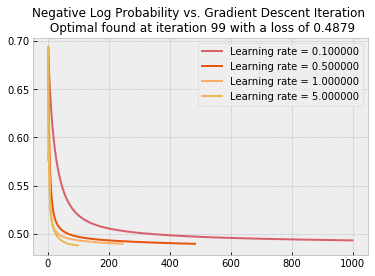

In [4]:
GD = LogisticRegression()
global colorIndex
colorIndex = 0
for learningRate in [0.1, 0.5, 1, 5]:
    GD.setParameters(convergenceError=0.005, learningRate=learningRate, GDvisualization=True)
    GD.runRegression('GD')
    colorIndex += 1
plt.show()

Accuracy is 66.66666666666666 % for data iris with SGD at iteration 16199
Log likelihood is 7.135707048538181 

weight: [[-0.95018697]
 [ 0.42424663]
 [-1.39348558]
 [ 0.70514379]
 [-1.07596021]]


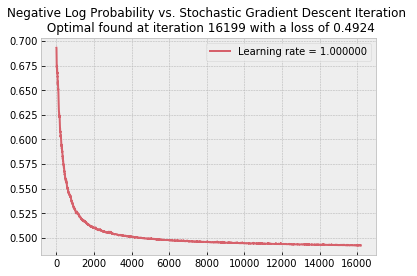

In [6]:
SGD = LogisticRegression()
global colorIndex
colorIndex = 0
for learningRate in [0.1, 0.5, 1, 5]:
    SGD.setParameters(convergenceError=0.005, learningRate=learningRate, batchSize=1, GDvisualization=True)
    SGD.runRegression('SGD')
    colorIndex += 1
plt.show()